# Generalized Geometry


This notebook show you how to assemble multiple non-modular detectors like JungFrau and ePix100.

In [1]:
import multiprocessing as mp
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from extra_data import RunDirectory
from pyfoamalgo.geometry import EPix100Geometry, JungFrauGeometry, stack_detector_modules
from pyfoamalgo import nanmean

mp.cpu_count()

72

## JungFrau Geometry

In [2]:
# TODO: find a better sample run
run = RunDirectory("/gpfs/exfel/exp/XMPL/201750/p700000/raw/r0021")

run.info()

# of trains:    12307
Duration:       0:20:30.7
First train ID: 106739917
Last train ID:  106752223

0 detector modules ()

5 instrument sources (excluding detectors):
  - SA1_XTD2_XGM/XGM/DOOCS:output
  - SPB_IRDA_JNGFR/DET/MODULE_2:daqOutput
  - SPB_IRDA_JNGFR/DET/MODULE_6:daqOutput
  - SPB_IRDA_JNGFR/DET/MODULE_7:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

6 control sources: (1 entry per train)
  - ACC_SYS_DOOCS/CTRL/BEAMCONDITIONS
  - SA1_XTD2_ATT/MDL/MAIN
  - SA1_XTD2_MIRR-1/MOTOR/HMRY
  - SA1_XTD2_XGM/XGM/DOOCS
  - SPB_IRDA_JNGFR/DET/CONTROL
  - SPB_XTD9_XGM/XGM/DOOCS



In [3]:
_, train_data = run.train_from_index(0)

### Assembling without a geometry file

**Note:** ``stack_detector_modules`` returns an array-like wrapper around the existing arrays which avoid the data copy.

In [4]:
modules_data = stack_detector_modules(
    train_data, 'SPB_IRDA_JNGFR/DET/MODULE_*:daqOutput', 'data.adc', module_numbers=[1, 2, 3, 6, 7, 8])

modules_data.shape

(1, 6, 512, 1024)

In [5]:
# The whole image will be assembled from 6 modules and the layout is 3 x 2.
geom = JungFrauGeometry(3, 2)

In [6]:
n_pulses = modules_data.shape[0]

# Allocate the assembled image array and reuse it as far as possible to speed up data processing.
assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,), dtype=np.float32)
assembled.shape

(1, 1536, 2048)

In [7]:
t0 = time.perf_counter()

# Assemble modules and mask ASIC edge pixels.
geom.position_all_modules(modules_data, out=assembled, ignore_asic_edge=True)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Assembling a train with 1 pulses takes: 10.6 ms


**Note:** `nanmean` implemented in `pyfoamalgo` is much faster than `numpy.nanmean`.

In [8]:
t0 = time.perf_counter()

# Calculate the average (taking into account nan) of the assembled image.
assembled_mean = nanmean(assembled, axis=0)

print(f"Averaging a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Averaging a train with 1 pulses takes: 13.8 ms


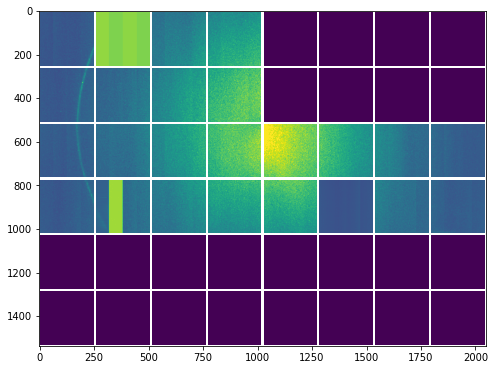

In [9]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled_mean, vmin=0, vmax=10000)

### Assembling with a geometry file

In [10]:
# Now we will have assemble 8 modules instead of 6.
modules_data = stack_detector_modules(
    train_data, 'SPB_IRDA_JNGFR/DET/MODULE_*:daqOutput', 'data.adc', module_numbers=[1, 2, 3, 4, 5, 6, 7, 8])

In [11]:
geom = JungFrauGeometry.from_crystfel_geom('jungfrau8.geom', 4, 2)

assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,), dtype=np.float32)
assembled.shape

(1, 2155, 2260)

In [12]:
t0 = time.perf_counter()

# Assemble modules and mask ASIC edge pixels.
geom.position_all_modules(modules_data, out=assembled, ignore_asic_edge=True)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Assembling a train with 1 pulses takes: 2.4 ms


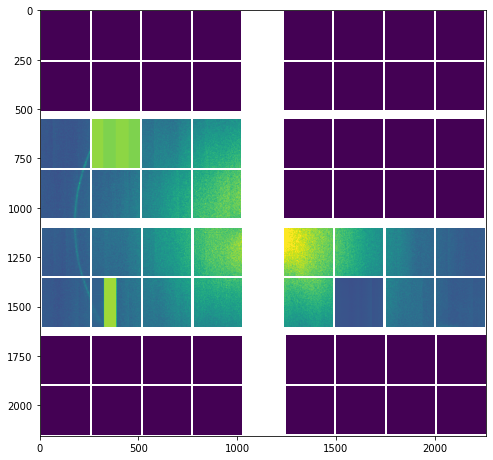

In [13]:
_, ax = plt.subplots(figsize=(8, 8))

assembled_mean = nanmean(assembled, axis=0)
ax.imshow(assembled_mean, vmin=0, vmax=10000)

## ePix100 Geometry

In [ ]:
run = RunDirectory("")

run.info()

In [ ]:
_, train_data = run.train_from_index(100)

In [ ]:
modules_data = stack_detector_modules(
    train_data, 'MID_EXP_EPIX-*/DET/RECEIVER:daqOutput', 'data.image.pixels', module_numbers=[1, 2])

# ePix100 is a train-resolved detector
modules_data.shape

### Stack modules without a geometry file

In [ ]:
# The whole image will be assembled from 2 modules and the layout is 2 x 1.
geom = EPix100Geometry(2, 1)

In [ ]:
# Allocate the assembled image array and reuse it as far as possible to speed up data processing.
assembled = geom.output_array_for_position_fast(dtype=np.float32)
assembled.shape

In [ ]:
t0 = time.perf_counter()

# Assemble modules and mask ASIC edge pixels.
geom.position_all_modules(modules_data, out=assembled, ignore_asic_edge=True)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

In [ ]:
_, ax = plt.subplots(figsize=(4, 8))

ax.imshow(assembled)